Matplotlib is building the font cache; this may take a moment.


Tabu Search Result:
  Best solution found: [-0.99623048  0.99534049]
  Best cost found: 1.9902678069507012


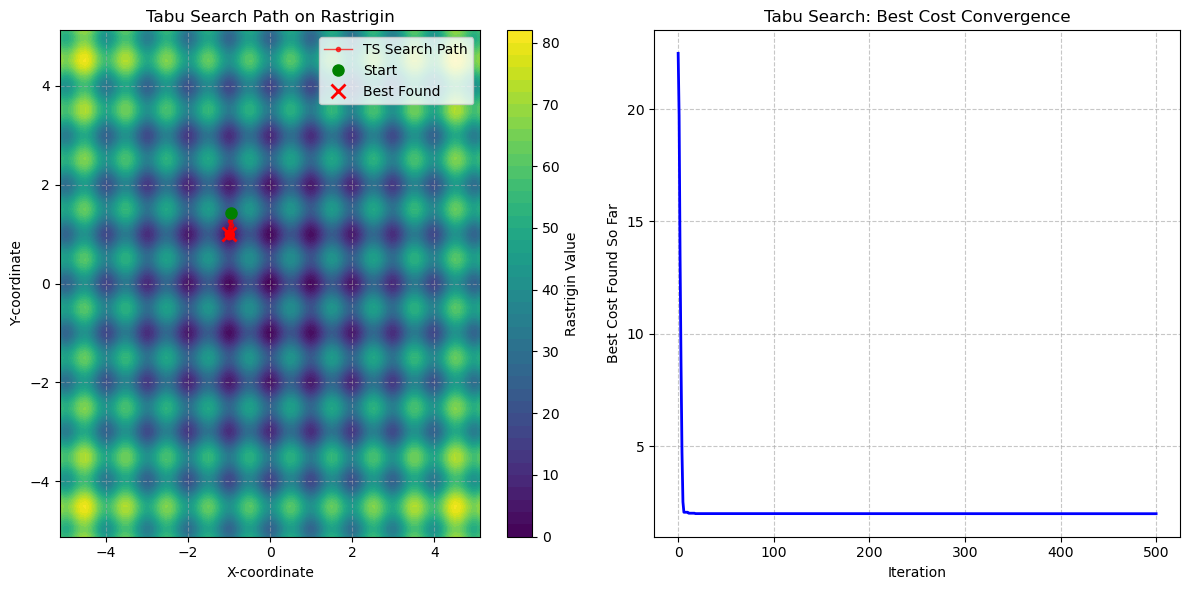

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque # For tabu list

# --- 1. Define the Objective Function (2D Rastrigin) ---
def rastrigin(x):
    """
    2D Rastrigin function.
    Global minimum is 0 at (0,0).
    Domain: typically [-5.12, 5.12] for each dimension.
    """
    A = 10
    return A * 2 + (x[0]**2 - A * np.cos(2 * np.pi * x[0])) + \
                   (x[1]**2 - A * np.cos(2 * np.pi * x[1]))

# --- Helper to discretize a continuous solution for tabu list ---
# Important for making tabu list comparable (e.g., [1.001, 2.003] vs [1.000, 2.000])
def discretize_solution(solution, precision=2):
    return tuple(round(s, precision) for s in solution)

# --- 2. Tabu Search Algorithm ---
def tabu_search(objective_func, bounds, max_iterations, tabu_tenure_length, step_size_factor=0.1):
    current_solution = np.array([random.uniform(b[0], b[1]) for b in bounds])
    current_cost = objective_func(current_solution)

    best_solution = np.copy(current_solution)
    best_cost = current_cost

    # Tabu list stores discretized solutions as (x_round, y_round) tuples
    tabu_list = deque(maxlen=tabu_tenure_length)
    
    # Data to plot
    path = [current_solution]
    best_costs_over_time = [best_cost]

    for iteration in range(max_iterations):
        neighborhood = []
        
        # Generate neighbors (small steps in different directions)
        # For a continuous problem, neighbors are typically generated by small random perturbations
        # or by defining a grid and moving to adjacent grid points.
        # Here, we'll generate a few random neighbors within a step radius
        num_neighbors = 20 # Number of neighbors to explore in each iteration
        for _ in range(num_neighbors):
            neighbor = current_solution + np.array([random.uniform(-step_size_factor, step_size_factor), 
                                                     random.uniform(-step_size_factor, step_size_factor)])
            # Clip to bounds
            for i in range(len(bounds)):
                neighbor[i] = max(bounds[i][0], min(bounds[i][1], neighbor[i]))
            neighborhood.append(neighbor)

        best_candidate_in_neighborhood = None
        best_candidate_cost = float('inf')
        
        # Evaluate neighbors and select the best non-tabu one
        for candidate_solution in neighborhood:
            candidate_cost = objective_func(candidate_solution)
            discretized_candidate = discretize_solution(candidate_solution)

            # Check if candidate is tabu
            is_tabu = discretized_candidate in tabu_list

            # Aspiration criterion: Overrule tabu if it's better than overall best
            if is_tabu and candidate_cost < best_cost:
                is_tabu = False # Aspiration allows this tabu move
            
            if not is_tabu:
                if candidate_cost < best_candidate_cost:
                    best_candidate_cost = candidate_cost
                    best_candidate_in_neighborhood = np.copy(candidate_solution)
        
        # Move to the best valid candidate
        if best_candidate_in_neighborhood is not None:
            current_solution = best_candidate_in_neighborhood
            current_cost = best_candidate_cost
            
            # Add current solution's discretized form to tabu list
            tabu_list.append(discretize_solution(current_solution))
        else:
            # If all valid neighbors are tabu and no aspiration met, try a random jump (diversification)
            # or simply stay. For demo, a small random jump
            random_jump = np.array([random.uniform(-1, 1), random.uniform(-1, 1)]) # Larger jump
            current_solution = current_solution + random_jump
            for i in range(len(bounds)):
                current_solution[i] = max(bounds[i][0], min(bounds[i][1], current_solution[i]))
            current_cost = objective_func(current_solution)
            
            tabu_list.append(discretize_solution(current_solution)) # Add to tabu
            

        # Update overall best solution found
        if current_cost < best_cost:
            best_solution = np.copy(current_solution)
            best_cost = current_cost
        
        path.append(current_solution)
        best_costs_over_time.append(best_cost)

    return best_solution, best_cost, np.array(path), np.array(best_costs_over_time)

# --- 3. Run the Demo and Plot Results ---
if __name__ == "__main__":
    bounds = [(-5.12, 5.12), (-5.12, 5.12)] # Search domain for x and y
    max_iterations = 500 # Total iterations
    tabu_tenure_length = 15 # Length of the tabu list

    best_sol, best_val, path, best_costs_history = tabu_search(
        rastrigin, bounds, max_iterations, tabu_tenure_length
    )

    print(f"Tabu Search Result:")
    print(f"  Best solution found: {best_sol}")
    print(f"  Best cost found: {best_val}")

    # Plotting the Rastrigin surface and the search path
    x_grid = np.linspace(bounds[0][0], bounds[0][1], 100)
    y_grid = np.linspace(bounds[1][0], bounds[1][1], 100)
    X, Y = np.meshgrid(x_grid, y_grid)
    Z = np.array([rastrigin([X[i, j], Y[i, j]]) for i in range(X.shape[0]) for j in range(X.shape[1])]).reshape(X.shape)

    plt.figure(figsize=(12, 6))

    # Subplot 1: 2D Contour Plot with Search Path
    plt.subplot(1, 2, 1)
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar(label='Rastrigin Value')
    plt.plot(path[:, 0], path[:, 1], 'r-o', markersize=3, linewidth=1, alpha=0.7, label='TS Search Path')
    plt.plot(path[0, 0], path[0, 1], 'go', markersize=8, label='Start')
    plt.plot(best_sol[0], best_sol[1], 'rx', markersize=10, markeredgewidth=2, label='Best Found')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Tabu Search Path on Rastrigin')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    # Subplot 2: Best Cost over Time
    plt.subplot(1, 2, 2)
    plt.plot(best_costs_history, 'b-', linewidth=2)
    plt.xlabel('Iteration')
    plt.ylabel('Best Cost Found So Far')
    plt.title('Tabu Search: Best Cost Convergence')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()